In [1]:
import torch

from src.utils import *
import os
import IPython.display as ipd
import logging

from src.resnet_model import SpectrogramModel
import torch.nn as nn
import librosa


logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [3]:
seed_everything(1234)
set_gpu(-1)
plt.style.use('dark_background')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
script_dir = os.getcwd()

GPU selected: 1 - Quadro P6000


In [4]:
# https://github.com/hrtlacek/SNR/blob/main/SNR.ipynb
def compute_snr(clean, perturbed):
    noise = clean - perturbed
    signal_power = np.mean(clean**2)
    noise_power = np.mean(noise**2) 

    if noise_power == 0:
        return float('inf')

    snr = 10 * np.log10((signal_power - noise_power)/noise_power)
    return snr

In [5]:
def compute_snr(clean_audio, perturbed_audio):
    """Compute SNR (Signal-to-Noise Ratio) between clean and perturbed audio without RMS normalization."""
    # Ensure both inputs are numpy arrays
    clean_audio = np.array(clean_audio)
    perturbed_audio = np.array(perturbed_audio)
    
    # Compute the noise (perturbation) as the difference between clean and perturbed audio
    noise = clean_audio - perturbed_audio
    
    # Compute the power of the clean signal
    signal_power = np.mean(clean_audio ** 2)
    
    # Compute the power of the noise (perturbation)
    noise_power = np.mean(noise ** 2)
    
    # Avoid division by zero in case of zero noise power
    if noise_power == 0:
        return np.inf  # Infinite SNR if there's no noise
    
    # Calculate SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

In [16]:
file_number = 1070406
attack = 'BIM'
attack_model = 'ResNet2D'
epsilon = '3dot0'
audio_path = os.path.join(script_dir, f'{attack}_{attack_model}_v0_pow_{epsilon}', f'{attack}_{attack_model}_v0_whole_pow', f'{attack}_{attack_model}_v0_pow_LA_E_{file_number}_{epsilon}.flac')
audio, _ = librosa.load(audio_path, sr=16000)
audio = audio[:47104]

clean_audio_path = os.path.join(script_dir, '..',f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_{file_number}.flac')
clean, _ = librosa.load(clean_audio_path, sr=16000)
clean = clean[:47104]
snr = compute_snr(clean, audio)
print(f'SNR: {snr}')

SNR: 15.405001640319824


In [17]:
print(f' clean min {np.min(clean)}, max {np.max(clean)}, mean {np.mean(clean)}, max abs {np.max(np.abs(clean))}')
#print(f' clean min {np.min(-clean)}, max {np.max(-clean)}, mean {np.mean(-clean)}, max abs {np.max(np.abs(-clean))}')
print(f' pert min {np.min(audio)}, max {np.max(audio)}, mean {np.mean(audio)}, max abs {np.max(np.abs(audio))}')

 clean min -0.753631591796875, max 0.614959716796875, mean 1.0158704526475049e-06, max abs 0.753631591796875
 pert min -0.753631591796875, max 0.63751220703125, mean 1.0126310598934651e-06, max abs 0.753631591796875


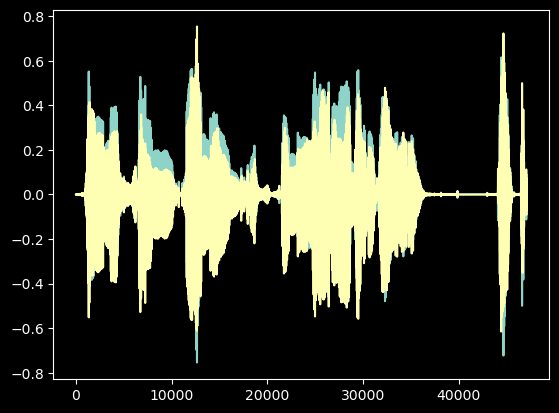

In [18]:
plt.figure()
plt.plot(clean)

plt.plot(-clean)
plt.show()

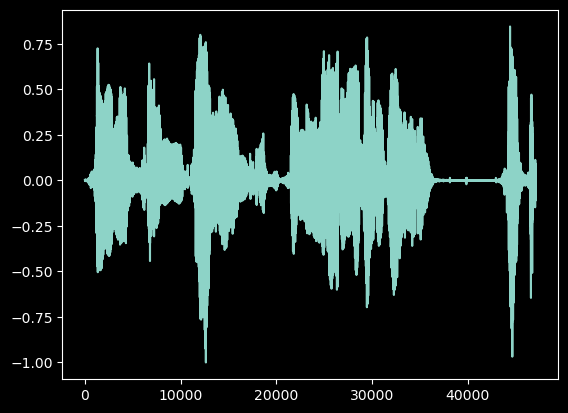

In [9]:
plt.figure()
plt.plot(audio)
plt.show()

In [19]:
ipd.Audio(audio, rate=16000)

In [11]:
ipd.Audio(clean, rate=16000)

In [ ]:
win_length = 2048
n_fft = 2048
hop_length = 512
window = 'hann'

s = librosa.stft(audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
mag = np.abs(s)

a = np.abs(s) ** 2
pow_spec = librosa.power_to_db(a, ref=np.max)

plt.figure()
librosa.display.specshow(pow_spec, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Perturbed {file_number}, power spec')
plt.show()

In [ ]:
win_length = 2048
n_fft = 2048
hop_length = 512
window = 'hann'

s = librosa.stft(clean, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
mag = np.abs(s)

a = np.abs(s) ** 2
pow_spec = librosa.power_to_db(a, ref=np.max)

plt.figure()
librosa.display.specshow(pow_spec, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Clean {file_number}, power spec.')
plt.show()

In [ ]:
from src.ResNet1D.resnet1d_model import SpectrogramModel1D
script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
config_path = os.path.join(parent_dir, 'config', 'resnet1d.yaml')
config = read_yaml(config_path)
check_dir = os.path.join(parent_dir, config['model_path_spec_pow_v0'])
model = SpectrogramModel1D().to(device)
model.load_state_dict(torch.load(check_dir, map_location=device), strict=False)
model.eval()

In [ ]:
# from src.SENet.senet1d_model import se_resnet341d_custom
# 
# script_dir = os.getcwd()
# parent_dir = os.path.dirname(script_dir)
# config_path = os.path.join(parent_dir, 'config', 'senet1d.yaml')
# config = read_yaml(config_path)
# check_dir = os.path.join(parent_dir, config['model_path_spec_pow_v0'])
# model = se_resnet341d_custom(num_classes=2).to(device)
# model.load_state_dict(torch.load(check_dir, map_location=device), strict=False)
# model.eval()

In [ ]:
# from src.LCNN_model.LCNN1d_model import LCNN1D
# 
# script_dir = os.getcwd()
# parent_dir = os.path.dirname(script_dir)
# config_path = os.path.join(parent_dir, 'config', 'LCNN1d.yaml')
# config = read_yaml(config_path)
# check_dir = os.path.join(parent_dir, config['model_path_spec_pow_v0'])
# model = LCNN1D().to(device)
# model.load_state_dict(torch.load(check_dir, map_location=device), strict=False)
# model.eval()

In [ ]:
batch_x = torch.from_numpy(audio).unsqueeze(dim=0).to(device)
out = model(batch_x)
print(torch.argmax(out))
print(out)

In [ ]:
batch_z = torch.from_numpy(clean).unsqueeze(dim=0).to(device)
outz = model(batch_z)
print(f'clean file eval {torch.argmax(outz)}, {outz}')
